# Task1: Analyse the Document Collection 

This task requires analyzing the fake job posting dataset from Kaggle, which contains about 18,000 job postings, of which about 800 are marked as fake. Below are the detailed analysis steps for this dataset, covering structural and linguistic analysis.

## Step1:Load and initially check the data

### a.Data Overview: 

The dataset contains 17 columns of information, including:

1. Text fields such as company_profile, description, requirements, benefits, etc. 
2. Category fields such as telecommuting, has_company_logo, employment_type, and target label fraudulent (0 = real recruitment, 1 = fake recruitment).

We will first load the dataset and do an initial check:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('/Users/laiciya/Downloads/fake_job_postings.csv')

In [3]:
# Basic info about the dataset
df.info() # Gives a summary of the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [5]:
df.describe().T # Summary statistics for numeric columns

,count,mean,std,min,25%,50%,75%,max
job_id,17880.0,8940.500000,5161.655742,1.0,4470.75,8940.5,13410.25,17880.0
telecommuting,17880.0,0.042897,0.202631,0.0,0.00,0.0,0.00,1.0
has_company_logo,17880.0,0.795302,0.403492,0.0,1.00,1.0,1.00,1.0
has_questions,17880.0,0.491723,0.499945,0.0,0.00,0.0,1.00,1.0
fraudulent,17880.0,0.048434,0.214688,0.0,0.00,0.0,0.00,1.0


In [7]:
df.isna().sum() # Check for missing values

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

***Check distribution of target classes-'fraudulent'***

In [10]:
df['fraudulent'].value_counts() # Checking distribution of target classes

fraudulent
0    17014
1      866
Name: count, dtype: int64

***Check distribution of target classes-'required_education'***

Only those non-fraudulent job postings need to be consider!

In [14]:
# Filter out rows with fraudulent jobs (only keep non-fraudulent jobs)
data = df[df['fraudulent'] == 0]
data['fraudulent'].value_counts() # Checking distribution of target classes

fraudulent
0    17014
Name: count, dtype: int64

In [16]:
# Filter rows based on required_education
education_levels = ["Bachelor's Degree","Master's Degree",'High School or equivalent']
data=data[data['required_education'].isin(education_levels)]

In [18]:
data['required_education'].value_counts() # Checking distribution of target classes

required_education
Bachelor's Degree            5045
High School or equivalent    1910
Master's Degree               385
Name: count, dtype: int64

***b. Insights from Initial Data Inspection***

1. The dataset contains missing values in several columns, particularly department, company_profile, requirements, benefits.
2. The class distribution is imbalanced: approximately 5% of jobs are labeled fraudulent.
3. The most common degree in the dataset is "Bachelor's Degree," with 5,045 entries.

## Step2: Handling Missing Data

Given that some columns have a high proportion of missing values, we can either remove these fields or impute missing values ​​based on the analytical importance of that field. For this task, we will replace missing values ​​with empty strings in text fields and delete irrelevant fields (for example, salary_range, job_id, location)

In [24]:
# Drop irrelevant columns
df.drop(['job_id', 'salary_range', 'location'], axis=1, inplace=True)

# Fill missing text-based columns with empty string
text_cols = df.select_dtypes(include='object').columns
df[text_cols] = df[text_cols].fillna("")

# After preprocessing, check for remaining missing values
df.isna().sum()

title                  0
department             0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64

## Step3: Data Exploration and Visualization

***a. Class Distribution Visualization***

To visualize the balance of real vs. fake job postings, we can use a pie chart:

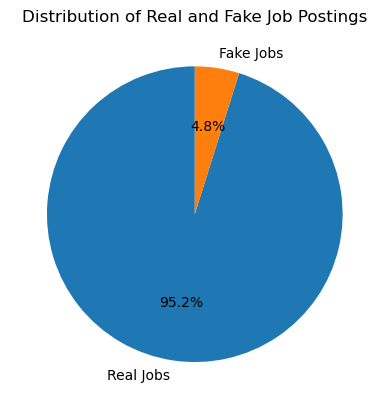

In [29]:
# Pie chart of class distribution
fraudulent_counts = df['fraudulent'].value_counts()
plt.pie(fraudulent_counts, labels=['Real Jobs', 'Fake Jobs'], autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Real and Fake Job Postings')
plt.show()

This chart will show the imbalance between real and fake jobs in the dataset, which can impact classification performance.

***b. Correlation Between Features***

We can analyze correlations between various numerical fields (e.g., telecommuting, has_company_logo, etc.) and the target label to identify significant relationships.

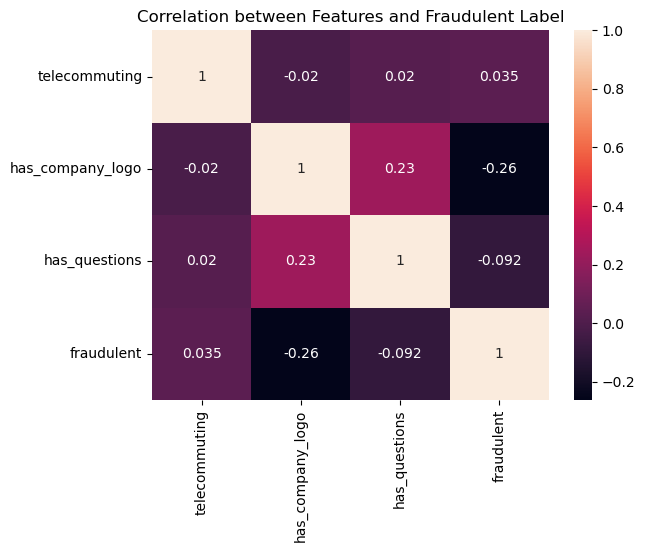

In [34]:
sns.heatmap(df[['telecommuting', 'has_company_logo', 'has_questions', 'fraudulent']].corr(), annot=True)
plt.title('Correlation between Features and Fraudulent Label')
plt.show()

Here, we may observe that has_company_logo is negatively correlated with fraudulent postings, indicating that legitimate jobs are more likely to have a company logo.

## Step4: Textual Analysis

***a. Creating a Combined Text Field***

We'll create a new column that combines the text-based columns (description, company_profile, requirements, etc.) into a single field for further analysis.

In [40]:
df['combined_text'] = df['company_profile'] + ' ' + df['description'] + ' ' + df['requirements'] + ' ' + df['benefits']

***b. Linguistic Characteristics***

To analyze the linguistic features, we’ll first clean the text data by removing HTML tags, special characters, and stopwords.

In [44]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Text cleaning function
def clean_text(text):
    text = re.sub(r'<.*?>', ' ', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    text = text.lower()  # Convert to lowercase
    stop_words = set(stopwords.words('english'))
    stemmer = SnowballStemmer('english')
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words])
    return text

# Apply cleaning function
df['cleaned_text'] = df['combined_text'].apply(clean_text)
#data['cleaned_text'] = data['combined_text'].apply(clean_text)

***c. Word Clouds for 
   (1.)Real vs. Fake Jobs
 (2.) Bachelor_Degree, High_School_or_equivalent and Master's Degree***

(1.)Real vs. Fake Jobs: To visualize common words in real and fake job postings, we’ll generate word clouds:

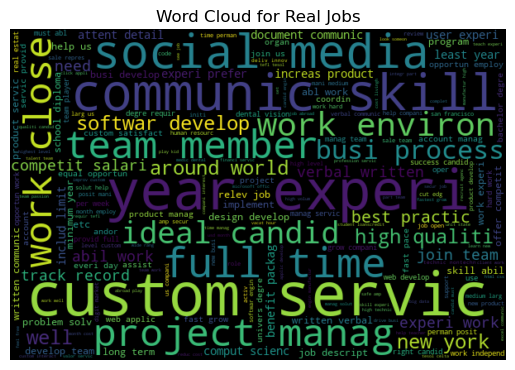

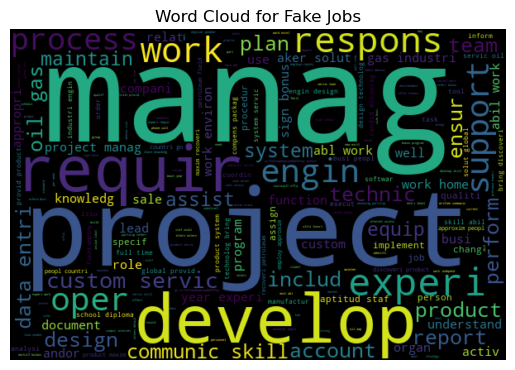

In [46]:
from wordcloud import WordCloud

# Word cloud for real jobs
real_jobs = df[df['fraudulent'] == 0]['cleaned_text'].values
real_wordcloud = WordCloud(width=600, height=400).generate(' '.join(real_jobs))
plt.imshow(real_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Real Jobs')
plt.show()

# Word cloud for fake jobs
fake_jobs = df[df['fraudulent'] == 1]['cleaned_text'].values
fake_wordcloud = WordCloud(width=600, height=400).generate(' '.join(fake_jobs))
plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Fake Jobs')
plt.show()

(2.) Bachelor_Degree, High_School_or_equivalent and Master's Degree: To visualize common words in Master's Degree, High School or equivalentand and Bachelor_Degree job postings, we’ll generate word clouds:

In [49]:

Education_Data= df[df['fraudulent'] == 0]
education_levels = ["Bachelor's Degree", "Master's Degree", 'High School or equivalent']
Education_Data = Education_Data[Education_Data['required_education'].isin(education_levels)]
print(Education_Data['required_education'].value_counts() ) # Checking distribution of target classes


required_education
Bachelor's Degree            5045
High School or equivalent    1910
Master's Degree               385
Name: count, dtype: int64


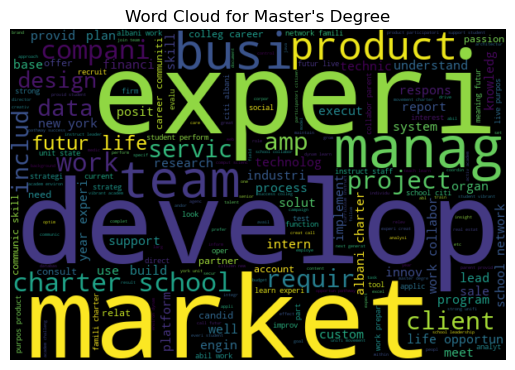

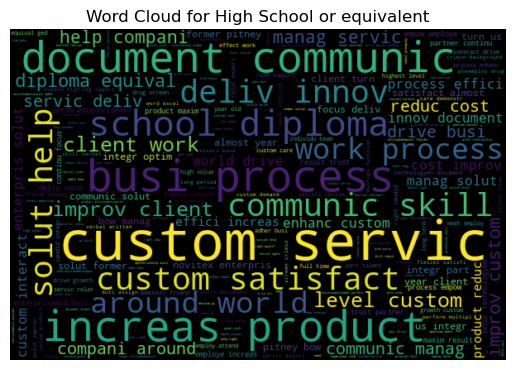

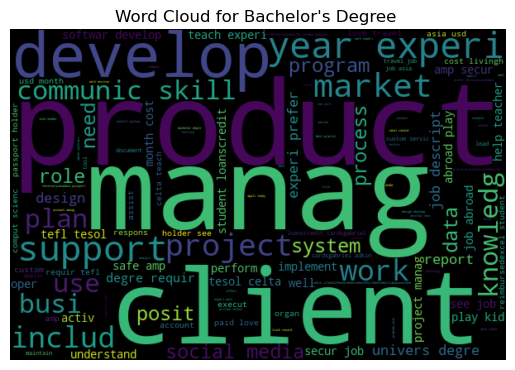

In [51]:
from wordcloud import WordCloud


Master_Degree =Education_Data[Education_Data["required_education"] == "Master's Degree"]['cleaned_text'].values
Master_Degree_wordcloud = WordCloud(width=600, height=400).generate(' '.join(Master_Degree))
plt.imshow(Master_Degree_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Master's Degree")
plt.show()

# Word cloud for High School or equivalent
High_School_or_equivalent =Education_Data[Education_Data["required_education"] == 'High School or equivalent']['cleaned_text'].values
High_School_or_equivalent_wordcloud = WordCloud(width=600, height=400).generate(' '.join(High_School_or_equivalent))
plt.imshow(High_School_or_equivalent_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for High School or equivalent")
plt.show()


# Word cloud for Bachelor's Degree 
Bachelor_Degree  =Education_Data[Education_Data["required_education"] == "Bachelor's Degree"]['cleaned_text'].values
Bachelor_Degree_wordcloud = WordCloud(width=600, height=400).generate(' '.join(Bachelor_Degree))
plt.imshow(Bachelor_Degree_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Bachelor's Degree ")
plt.show()

***d. Text Length Comparison***

We’ll compare the length of job descriptions between real and fake jobs to see if there is a noticeable difference.

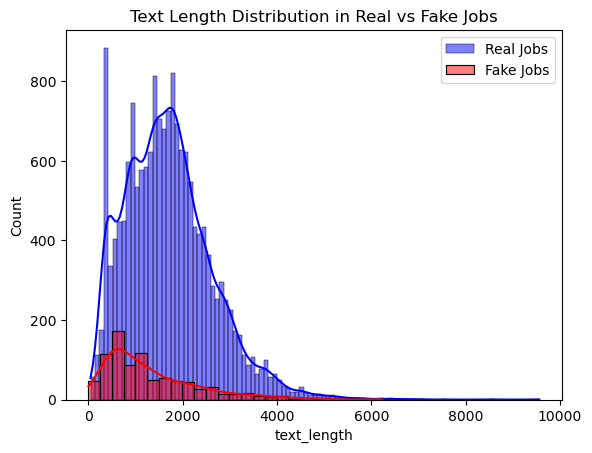

In [55]:
df['text_length'] = df['cleaned_text'].apply(len)

# Distribution of text length
sns.histplot(df[df['fraudulent'] == 0]['text_length'], color='blue', label='Real Jobs', kde=True)
sns.histplot(df[df['fraudulent'] == 1]['text_length'], color='red', label='Fake Jobs', kde=True)
plt.legend()
plt.title('Text Length Distribution in Real vs Fake Jobs')
plt.show()


Typically, fraudulent job postings may have shorter descriptions, as seen in the text length distribution.

required_education
Bachelor's Degree            5045
High School or equivalent    1910
Master's Degree               385
Name: count, dtype: int64


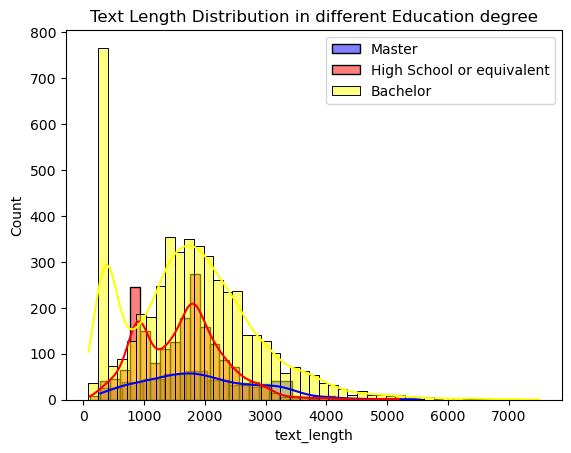

In [60]:
df['text_length'] = df['cleaned_text'].apply(len)

Education_Data= df[df['fraudulent'] == 0]
education_levels = ["Bachelor's Degree", "Master's Degree", 'High School or equivalent']
Education_Data = Education_Data[Education_Data['required_education'].isin(education_levels)]
print(Education_Data['required_education'].value_counts() ) # Checking distribution of target classes


# Distribution of text length
sns.histplot(Education_Data[Education_Data["required_education"] == "Master's Degree"]['text_length'], color='blue', label='Master', kde=True)
sns.histplot(Education_Data[Education_Data["required_education"] == 'High School or equivalent']['text_length'], color='red', label='High School or equivalent', kde=True)
sns.histplot(Education_Data[Education_Data["required_education"] == "Bachelor's Degree"]['text_length'], color='yellow', label='Bachelor', kde=True)

plt.legend()
plt.title('Text Length Distribution in different Education degree')
plt.show()


## Step5. Results and Conclusion

Analysis Summary:

1. Structural Characteristics:

(a) Real job postings often include a company logo, whereas fake postings typically do not. Additionally, fraudulent postings tend to have shorter text fields and contain fewer details compared to legitimate ones.
(b) The length of text fields across different education levels is generally similar, though Bachelor-level postings tend to have a notably high count with a consistent shorter length.



2. Linguistic Characteristics:

(a) Word cloud analysis reveals that fraudulent job postings use more generic and enticing terms (e.g., "Project"), while real postings are more specific, detailing responsibilities and qualifications (e.g., "full time").
(b) Master-level job postings frequently include terms like "develop" and "team," while Bachelor-level postings emphasize words like "client," "product," and "manage." High school or equivalent jobs commonly use terms such as "customer service" and "around the world."



3. Key Differences:

Fields such as the description and company profile exhibit noticeable differences in text length and content quality between legitimate and fraudulent job postings.


Conclusion:

For classification tasks that involve predicting the required education level of a job posting, I will use the following features: ['description', 'title', 'company_profile', 'requirements'].
For detecting fraudulent job postings, I will rely on the description field and whether or not a company logo is present.